In [69]:
from os import listdir,mkdir
from os.path import isfile, join, splitext,exists
from scipy.io import wavfile
from scipy import signal
import sys
import librosa
import matplotlib.pyplot as plt
import numpy as np
from madmom.audio.filters import MelFilterbank 
from pydub import AudioSegment
import os
import soundfile as sf

path_giant_audio="Dataset/Key/GS/Audio"
path_giant_ann="Dataset/Key/GS/Ann"
path_giant_image="Dataset/Key/GS/Image_spec"
path_gtzan_audio="Dataset/Key/GTZAN/Audio"
path_gtzan_ann="Dataset/Key/GTZAN/Ann"
path_gtzan_image="Dataset/Key/GTZAN/Image_spec"
lst_name_chords=['A major','Bb major','B major','C major','Db major','D major','Eb major','E major','F major','Gb major','G major','Ab major','A minor','Bb minor','B minor','C minor','Db minor','D minor','Eb minor','E minor','F minor','Gb minor','G minor','Ab minor']
lst_chords=range(len(lst_name_chords))


def convert_to_wav(path_audio):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    #for each file, convert it into wav
    for f in onlyfiles:
        sound = AudioSegment.from_mp3(f"{path}/{f}")
        dst = f"{path}/{splitext(f)[0]}.wav"
        sound.export(dst, format="wav")
        os.remove(f"{path}/{f}")
        
def convert_annotations(path_ann):
    #it may happen that we have annotation written like 'db minor'. We need to convert it as a number
    #It is adapted to the Dictionary of GTZAN, where tehre is only the Major and Minor scale ordered as the following list is
    
    onlyfiles = [f for f in listdir(path_ann) if isfile(join(path_ann, f))]
    for f in onlyfiles:
        a=open(f"{path_ann}/{f}","r")
        chord=a.readlines()
        a.close()
        numb_chord=lst_chords[lst_name_chords.index(chord[0])]
        a=open(f"{path_ann}/{splitext(f)[0]}.txt","w")
        a.write(str(numb_chord))
        a.close()
        
def rename_key_file(path):
    #I delete the key file for faster stuff
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    for f in onlyfiles:
        os.rename(f"{path}/{f}",f"{path}/{splitext(f)[0]}.txt")
        if "lerch" in f:
            f2=((splitext(f)[0])[:len(f)-10])
            os.rename(f"{path}/{f}",f"{path}/{f2}.txt")
        
def data_augmentation(path_audio,path_ann):
    #1st data augmentation-> pitch shifting, by 2,-2,6,-6 semitones
    f_audio = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    
    for f in f_audio:
        y, sr = librosa.load(f"{path_audio}/{f}")
        lst_name_file_shifted=["2","2n","6","6n"]
        lst_shift=[2,-2,6,-6]
        
        #memorize the chord
        a=open(f"{path_ann}/{splitext(f)[0]}.txt","r")
        chord=a.readlines()
        a.close()
        for s in lst_shift:
            #write the audio shifted
            audio=librosa.effects.pitch_shift(y, sr, n_steps=s)
            sf.write(f'{path_audio}/{lst_name_file_shifted[lst_shift.index(s)]}_{f}', audio, sr,'PCM_24')
            #modify the ann
            new_chord=lst_chords[(int(chord[0])+s) % len(lst_chords)]
            a=open(f"{path_ann}/{lst_name_file_shifted[lst_shift.index(s)]}_{splitext(f)[0]}.txt",'w')
            a.write(str(new_chord))
            a.close()
            
    #2nd data augmentation -> divide the original audio in 15 sec audio, it is needed just this lenght in order to achieve some results
    f_audio = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    for f in f_audio:
        y,sr=librosa.load(f"{path_audio}/{f}")
        if len(y)>sr*15:
            count=1
            
            #memorize the chord
            a=open(f"{path_ann}/{splitext(f)[0]}.txt","r")
            bpm=a.readlines()
            a.close()
            
            while True:
                if(sr*15*count<=len(y)):
                    
                    y_new=y[sr*15*(count-1):sr*15*count]
                    sf.write(f'{path_audio}/{splitext(f)[0]}_{count}.wav', y_new, sr,'PCM_24')
                    if count==1: #rename the original file
                        os.rename(f"{path_ann}/{splitext(f)[0]}.txt", f"{path_ann}/{splitext(f)[0]}_{count}.txt")
                    else:
                        a=open(f"{path_ann}/{splitext(f)[0]}_{count}.txt","w")
                        a.write(str(bpm[0]))
                        a.close()
                    count+=1
                else:
                    break
                    
                    
            os.remove(f"{path_audio}/{f}")

        
#rename_key_file(path_giant_ann)
#rename_key_file(path_gtzan_ann)
#convert_annotations(path_giant_ann)
#data_augmentation(path_giant_audio,path_giant_ann)
data_augmentation(path_gtzan_audio,path_gtzan_ann)

KeyboardInterrupt: 

<ipython-input-72-fbe569e4cbe9>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


KeyboardInterrupt: 

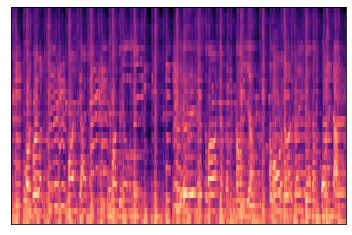

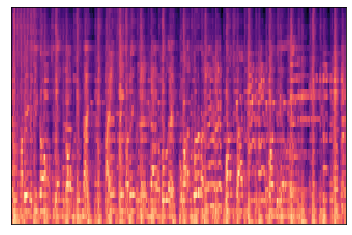

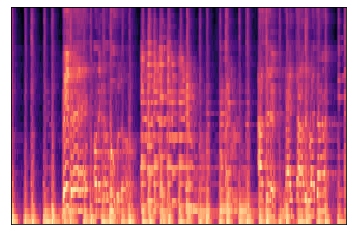

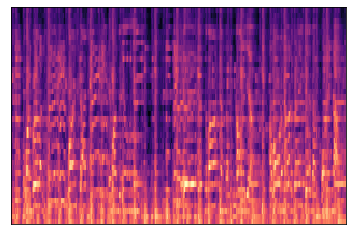

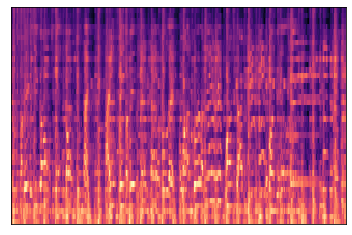

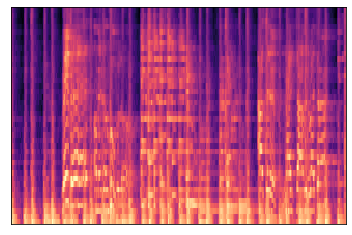

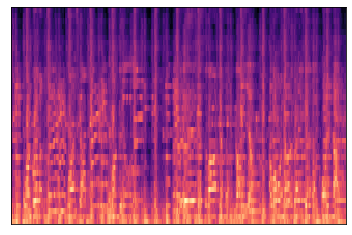

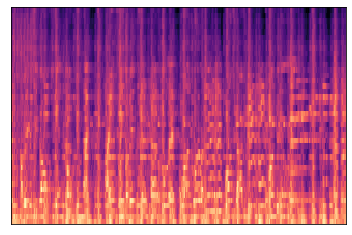

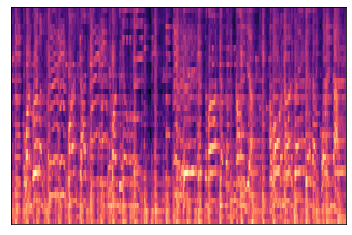

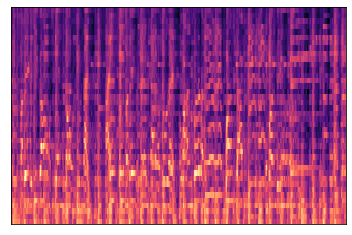

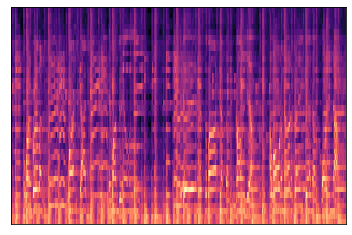

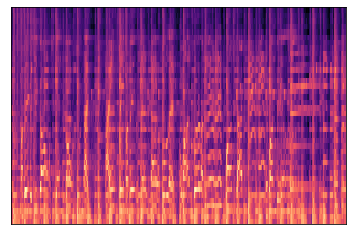

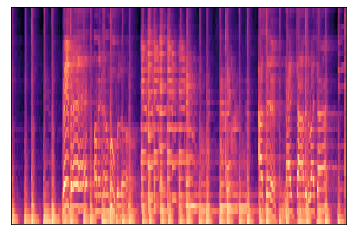

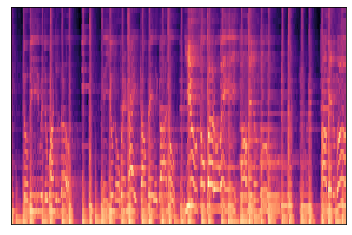

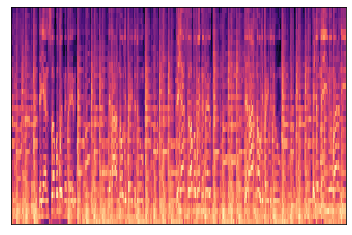

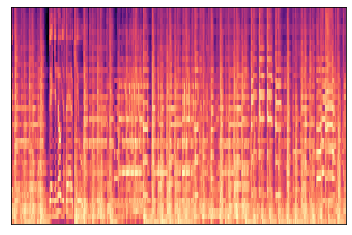

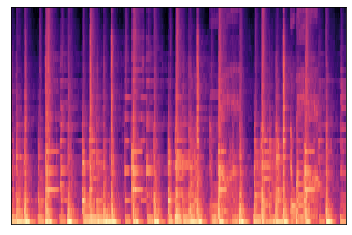

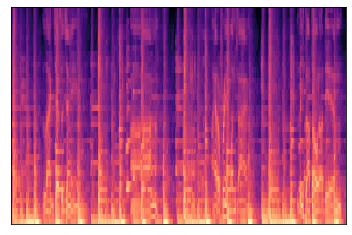

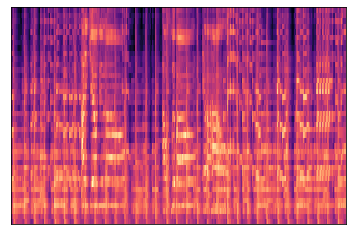

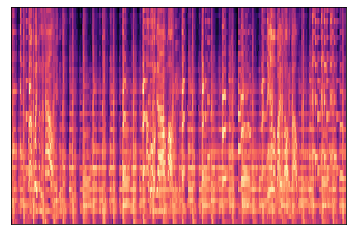

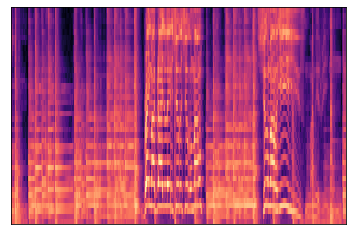

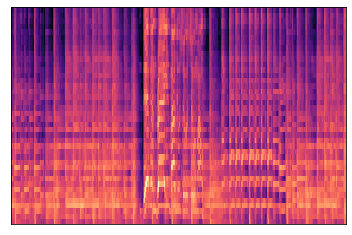

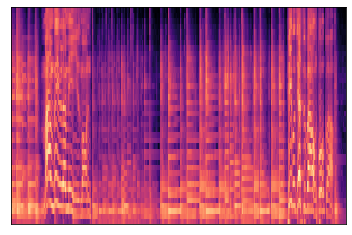

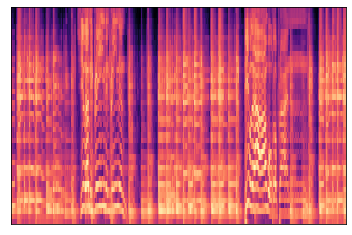

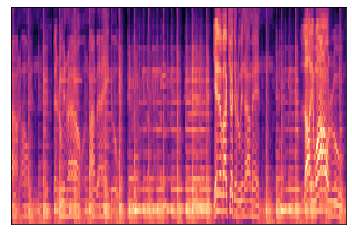

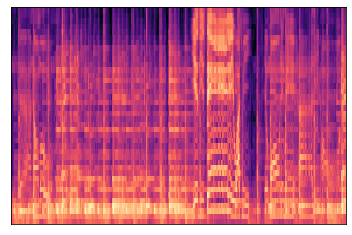

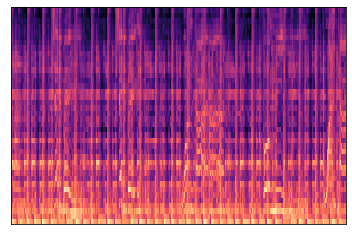

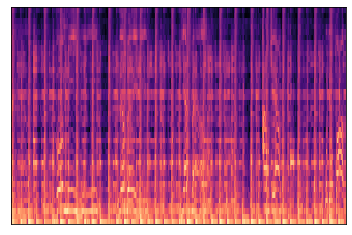

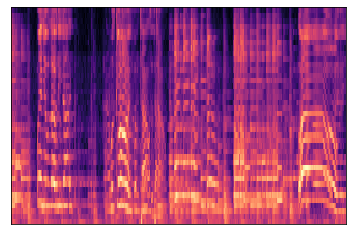

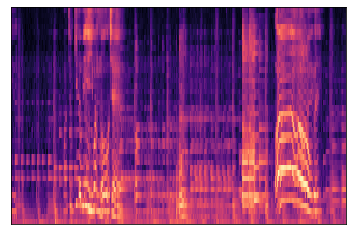

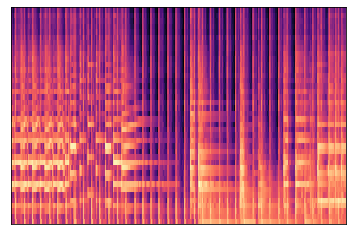

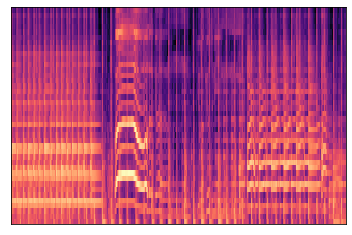

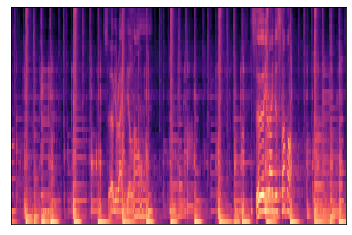

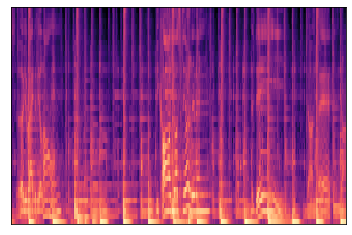

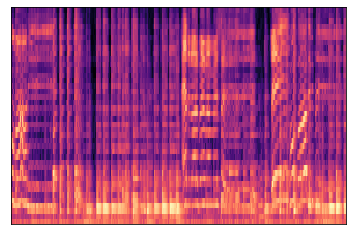

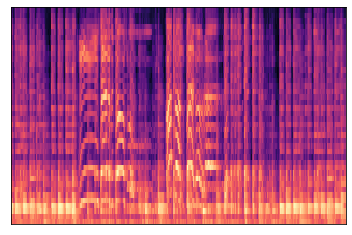

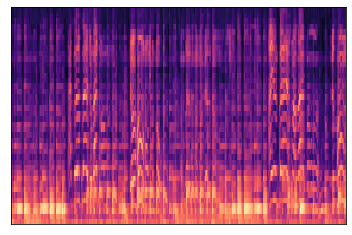

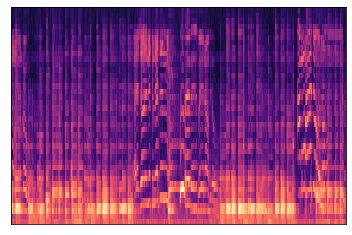

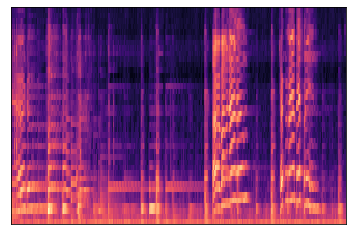

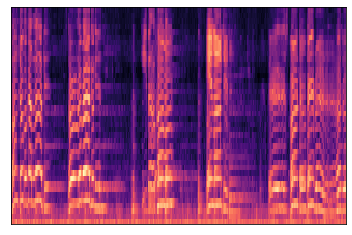

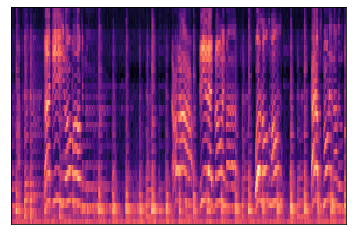

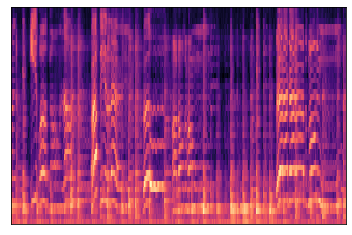

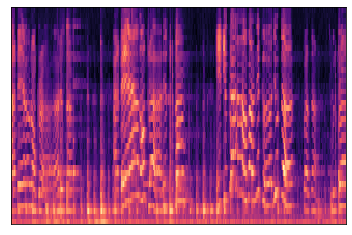

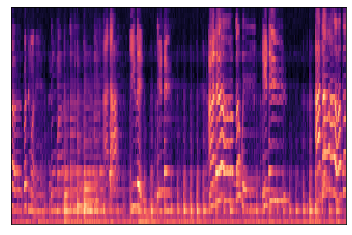

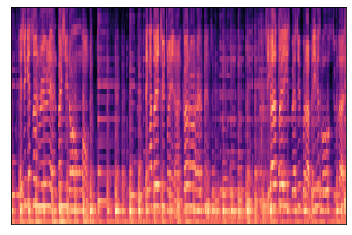

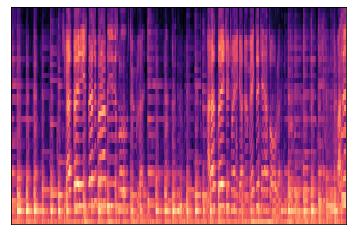

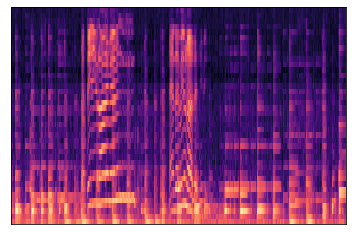

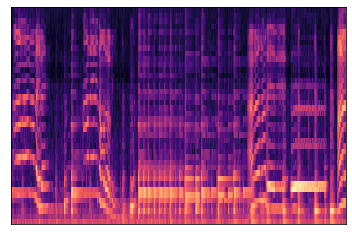

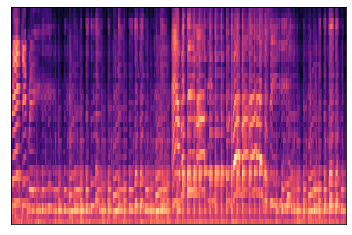

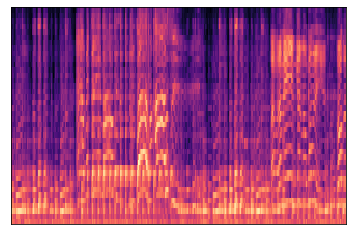

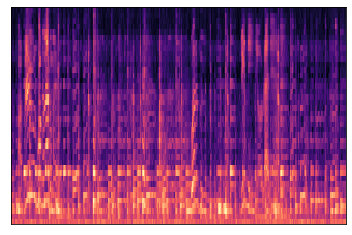

In [72]:
def creation_spectrograms(path_audio,path_img):
    
    onlyfiles = [f for f in listdir(path_audio) if isfile(join(path_audio, f))]
    for f in onlyfiles:
        y,sr=librosa.load(f"{path_audio}/{f}",sr=22050)
        ps = librosa.feature.melspectrogram(y=y,n_fft=1024, hop_length=1024//2,sr=sr,power=1,n_mels=40, fmin=20, fmax=5000)
        mels = np.log(ps + 1e-9)
        mels = librosa.power_to_db(ps, ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mels, sr=sr)
        plt.savefig(f"{path_img}/{splitext(f)[0]}.jpeg")

#creation_spectrograms(path_giant_audio,path_giant_image)
creation_spectrograms(path_gtzan_audio,path_gtzan_image)

In [ ]:
f_audio = [f for f in listdir(path_gtzan_ann) if isfile(join(path_audio, f))]